<a href="https://colab.research.google.com/github/rajuzumaki2207/Time_series_Sequence/blob/main/RUL_TurboFan/TurboFan_Engine_RUL_W_hist_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## About data set
https://www.kaggle.com/datasets/behrad3d/nasa-cmaps


Prognostics and health management is an important topic in industry for predicting state of assets to avoid downtime and failures. This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.

Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

### Prediction Goal
In this dataset the goal is to predict the remaining useful life (RUL) of each engine in the test dataset. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset

### Data set features
Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sb
import xgboost as xgb
import lightgbm as lightgbm


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score


## Model Selection
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

import os



In [113]:
## Read Data (By senson data from Dataset desc)

col = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [114]:
## Train data
train = pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/train_FD001.txt", sep = " ", names=col)

In [115]:
train.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  \
0    14.62  ...   8138.62    8.4195      0.03       392      2388     100.0   
1    14.62  ...   8131.49    8.4318      0.03       392      2388     100.0   
2    14.62  ...   8133.23    8.4178      0.03       390      2388     100.0   
3    14.62  ...   8133.83    8.3682      0.03       392      2388     100.0   
4    14.62  ...   8133.80    8.4294      0.03       393      2388     100.0   

   sensor20  sensor21  sensor22  sensor23  
0     39.06   23.4190       NaN       NaN  
1     39.00   23.4236       NaN       NaN  
2     38.95   23.3442       NaN       NaN  
3     38.88   23.3739       NaN       NaN  
4     38.90   23.4044       NaN       NaN  

[5 rows x 28 columns]

In [116]:
## Test data
test = pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/test_FD001.txt", sep = " ", names =col)

In [117]:
test.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1  0.0023  0.0003  100.0   518.67   643.02  1585.29  1398.21   
1   1      2 -0.0027 -0.0003  100.0   518.67   641.71  1588.45  1395.42   
2   1      3  0.0003  0.0001  100.0   518.67   642.46  1586.94  1401.34   
3   1      4  0.0042  0.0000  100.0   518.67   642.44  1584.12  1406.42   
4   1      5  0.0014  0.0000  100.0   518.67   642.51  1587.19  1401.92   

   sensor5  ...  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  \
0    14.62  ...   8125.55    8.4052      0.03       392      2388     100.0   
1    14.62  ...   8139.62    8.3803      0.03       393      2388     100.0   
2    14.62  ...   8130.10    8.4441      0.03       393      2388     100.0   
3    14.62  ...   8132.90    8.3917      0.03       391      2388     100.0   
4    14.62  ...   8129.54    8.4031      0.03       390      2388     100.0   

   sensor20  sensor21  sensor22  sensor23  
0     38.86   23.3735       NaN       NaN  
1     39.02   23.3916       NaN       NaN  
2     39.08   23.4166       NaN       NaN  
3     39.00   23.3737       NaN       NaN  
4     38.99   23.4130       NaN       NaN  

[5 rows x 28 columns]

In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   op1       20631 non-null  float64
 3   op2       20631 non-null  float64
 4   op3       20631 non-null  float64
 5   sensor1   20631 non-null  float64
 6   sensor2   20631 non-null  float64
 7   sensor3   20631 non-null  float64
 8   sensor4   20631 non-null  float64
 9   sensor5   20631 non-null  float64
 10  sensor6   20631 non-null  float64
 11  sensor7   20631 non-null  float64
 12  sensor8   20631 non-null  float64
 13  sensor9   20631 non-null  float64
 14  sensor10  20631 non-null  float64
 15  sensor11  20631 non-null  float64
 16  sensor12  20631 non-null  float64
 17  sensor13  20631 non-null  float64
 18  sensor14  20631 non-null  float64
 19  sensor15  20631 non-null  float64
 20  sensor16  20631 non-null  fl

<font color="red">**Looks like sensors 22 and 23 are faulty**

In [107]:
## Check the same  for test set

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13096 non-null  int64  
 1   cycle     13096 non-null  int64  
 2   op1       13096 non-null  float64
 3   op2       13096 non-null  float64
 4   op3       13096 non-null  float64
 5   sensor1   13096 non-null  float64
 6   sensor2   13096 non-null  float64
 7   sensor3   13096 non-null  float64
 8   sensor4   13096 non-null  float64
 9   sensor5   13096 non-null  float64
 10  sensor6   13096 non-null  float64
 11  sensor7   13096 non-null  float64
 12  sensor8   13096 non-null  float64
 13  sensor9   13096 non-null  float64
 14  sensor10  13096 non-null  float64
 15  sensor11  13096 non-null  float64
 16  sensor12  13096 non-null  float64
 17  sensor13  13096 non-null  float64
 18  sensor14  13096 non-null  float64
 19  sensor15  13096 non-null  float64
 20  sensor16  13096 non-null  fl

## Visualize Max Cycle vs Engine ID

In [ ]:
print ("Total Nulls in sensor 22 is" ,test.sensor22.isnull().sum())
print ("Total Nulls in sensor 23 is" ,test.sensor23.isnull().sum())

Total Nulls in sensor 22 is 13096
Total Nulls in sensor 23 is 13096


In [8]:
## Beautify plots

plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20,10)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [ ]:
## id are engine/fleet identification and cycles are flight cycles before failure
train.groupby('id')['cycle'].max()

id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

In [ ]:
import plotly.express as px

fig =px.bar(train, x=train.id.unique(), y =train.groupby('id')['cycle'].count(), title="Engine ID v Cycle Time",labels={
                     "x": "Engine ID",
                     "y" : "Cycle"} , template="plotly_dark")
fig.show()

In [9]:
test_results=pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/RUL_FD001.txt",sep=" ",header=None)

In [10]:
test_results.drop(1, axis =1, inplace=True)

In [11]:
test_results.columns = ['RUL']

In [12]:
test_results['id'] =  test_results.index.values +1 

In [13]:
test_results

RUL   id
0   112    1
1    98    2
2    69    3
3    82    4
4    91    5
..  ...  ...
95  137   96
96   82   97
97   59   98
98  117   99
99   20  100

[100 rows x 2 columns]

In [14]:
rul = test.groupby('id')['cycle'].count().reset_index()

In [15]:
rul.columns = ['id', 'max']


In [16]:
test_results['rul_failed']= test_results['RUL'].values + rul['max'].values


In [17]:
test_results.drop('RUL', axis =1, inplace=True)

In [18]:
test = test.merge(test_results, on = ['id'], how='left')

In [19]:
test['remaining_cycle'] = test["rul_failed"].values -test["cycle"].values

In [20]:
train['remaining_cycle'] = train.groupby('id')["cycle"].transform(max) -train["cycle"].values

In [21]:
test.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1  0.0023  0.0003  100.0   518.67   643.02  1585.29  1398.21   
1   1      2 -0.0027 -0.0003  100.0   518.67   641.71  1588.45  1395.42   
2   1      3  0.0003  0.0001  100.0   518.67   642.46  1586.94  1401.34   
3   1      4  0.0042  0.0000  100.0   518.67   642.44  1584.12  1406.42   
4   1      5  0.0014  0.0000  100.0   518.67   642.51  1587.19  1401.92   

   sensor5  ...  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  \
0    14.62  ...      0.03       392      2388     100.0     38.86   23.3735   
1    14.62  ...      0.03       393      2388     100.0     39.02   23.3916   
2    14.62  ...      0.03       393      2388     100.0     39.08   23.4166   
3    14.62  ...      0.03       391      2388     100.0     39.00   23.3737   
4    14.62  ...      0.03       390      2388     100.0     38.99   23.4130   

   sensor22  sensor23  rul_failed  remaining_cycle  
0       NaN       NaN         143              142  
1       NaN       NaN         143              141  
2       NaN       NaN         143              140  
3       NaN       NaN         143              139  
4       NaN       NaN         143              138  

[5 rows x 30 columns]

In [22]:
train.drop(["sensor22", "sensor23"], axis=1, inplace=True)  ## Sensor 22 and 23 are droped as NAN are the only value

In [23]:
test.drop(["sensor22", "sensor23"], axis=1, inplace=True)  ## Sensor 22 and 23 are droped as NAN are the only value

In [24]:
cycles = 30
train['label'] = train['remaining_cycle'].apply(lambda x: 1 if x <= cycles else 0)
test['label'] = test['remaining_cycle'].apply(lambda x: 1 if x <= cycles else 0)

In [25]:
op_set = ["op" + str(i) for i in range(1,4)]
sensor = ["sensor" + str(i) for i in range(1,22)]

In [26]:
test.columns

Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21',
       'rul_failed', 'remaining_cycle', 'label'],
      dtype='object')

In [ ]:
for i in range(1,21,3):

  fig = px.scatter_matrix(test, dimensions = ['cycle' , 'sensor' + str(i), 'sensor' + str(i+1), 'sensor' + str(i+2), 'sensor' + str(i+3)
  ], template ="plotly_dark")
  fig.show()

ValueError: ignored

In [27]:
test.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19"],axis=1,inplace=True)

In [28]:
X= train.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","remaining_cycle","label"],axis=1)

In [29]:
y=train.label

## Train test Split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=3)

In [ ]:
import lightgbm as lgb

clf =  lgb.LGBMClassifier(
    learning_rate = 0.01,
    n_estimators=5000,
    num_leaves=100,
   objective='binary', 
   metrics='auc',
   random_state=50,
   n_jobs=-1)



In [ ]:
clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, metrics='auc', n_estimators=5000,
               num_leaves=100, objective='binary', random_state=50)

In [ ]:
clf.score(X_test, y_test)

0.9607463048219045

In [ ]:
y_pred =clf.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, y_pred))
print('Roc Auc Score: ',roc_auc_score(y_test,y_pred))
print('Precision Score: ',precision_score(y_test, y_pred))
print('Recall Score: ',recall_score(y_test, y_pred))
print('f1 score: ',f1_score(y_test, y_pred))

Acc Score:  0.9607463048219045
Roc Auc Score:  0.9117584198662763
Precision Score:  0.8883161512027491
Recall Score:  0.8420195439739414
f1 score:  0.8645484949832776


In [ ]:
 fi = pd.Series(clf.feature_importances_)

In [ ]:
Feature = X_train.columns.tolist()

In [ ]:
df_FI = pd.DataFrame({"FI": fi, "Feature": Feature })

In [ ]:
df_FI

FI   Feature
0   27395       op1
1   16162       op2
2   27521   sensor2
3   28195   sensor3
4   27472   sensor4
5   27815   sensor7
6   17132   sensor8
7   27251   sensor9
8   22643  sensor11
9   26347  sensor12
10  15811  sensor13
11  28136  sensor14
12  30075  sensor15
13   7703  sensor17
14  20287  sensor20
15  28090  sensor21

In [ ]:
df_FI.sort_values(by=["FI"], ascending=False)

FI   Feature
12  30075  sensor15
3   28195   sensor3
11  28136  sensor14
15  28090  sensor21
5   27815   sensor7
2   27521   sensor2
4   27472   sensor4
0   27395       op1
7   27251   sensor9
9   26347  sensor12
8   22643  sensor11
14  20287  sensor20
6   17132   sensor8
1   16162       op2
10  15811  sensor13
13   7703  sensor17

In [ ]:
df_FI = df_FI.sort_values(by=["FI"], ascending=False)
fig = px.bar(df_FI, x="Feature", y = "FI", template = "plotly_dark")
fig.show()

## XGboost and RandomSearch

In [ ]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
stf_kf=StratifiedKFold(n_splits=5)
import xgboost as xgb
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05), 
         'scale_pos_weight': np.arange( 20, 200, 10)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
rs_cv_classifier.fit(X_train,y_train)
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,y_test))

Best Parameter: 
 {'subsample': 0.75, 'scale_pos_weight': 60, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.060000000000000005, 'gamma': 0.7999999999999999, 'colsample_bytree': 0.5500000000000002}
XGBClassifier Acc Score:  0.9556578628543736


In [ ]:
y_pred = rs_cv_classifier.predict(X_test)

In [ ]:
cm=confusion_matrix(y_test, y_pred)

In [ ]:
print (cm)

[[3392  121]
 [  62  552]]


In [ ]:
print("Test Accuracy Score: ", accuracy_score(y_test, y_pred))

Test Accuracy Score:  0.9556578628543736


In [ ]:
print('Acc Score: ',accuracy_score(y_test, y_pred))
print('Roc Auc Score: ',roc_auc_score(y_test,y_pred))
print('Precision Score: ',precision_score(y_test, y_pred))
print('Recall Score: ',recall_score(y_test, y_pred))
print('f1 score: ',f1_score(y_test, y_pred))

Acc Score:  0.9556578628543736
Roc Auc Score:  0.9322896528575574
Precision Score:  0.8202080237741456
Recall Score:  0.8990228013029316
f1 score:  0.8578088578088577


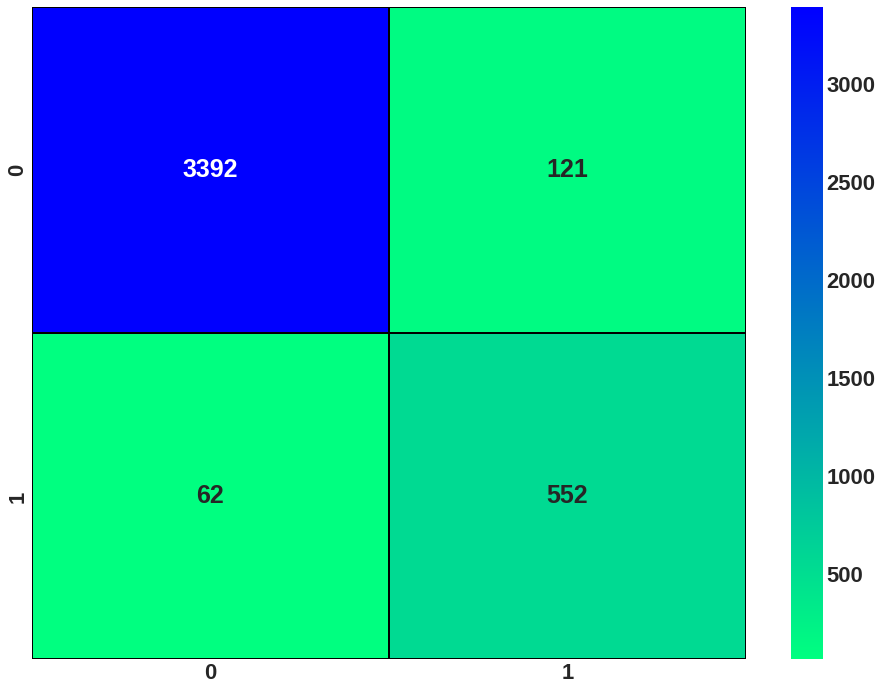

In [ ]:
plt.figure(figsize=(16,12))
sb.heatmap(cm,annot=True,annot_kws={"size": 25},linewidths=0.7,linecolor="black",cmap="winter_r",fmt="d")

**The above method although Correct but is not practical for doing Time Series forecasting as many times we don't have to knowledge or labels required to perform basic classification. XGboost and RandomForest can be used for feature selection.**

## Time Series Forecating
#### Approach 1
Predicting sensor values and setting ‘alarm’ thresholds. The component is deteriorated to a state in which breakdown is imminent when a sensor is predicted to cross this threshold. There are a few caveats using this approach for the current dataset.
1. Every sensor has to be modelled individually, therefore we cannot make use of interactions between sensors.
2. it requires a lot of domain knowledge for setting the appropriate thresholds and
3. it doesn’t directly inform us about our target feature, the Remaining Useful Life (RUL).

#### Approach 2
Vector Autoregression (VAR) type models. These types of models can handle multivariate timeseries, however the model initially creates lags of both our X and Y variables. Normally in timeseries the past values of Y play a large role in determining future values of Y. But since we assume our values for Y to be constant or linearly declining in the training set, incorporating these self-defined targets in the model and using them for prediction would highly influence model results and overemphasize the effect of Yt-1 on Yt. 

#### Approach 3
Distributed lag models. Basically, a regression model where you have full control over how many lags you add for each variable.


## Visualize Sensor Data

In [152]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['id'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['id']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


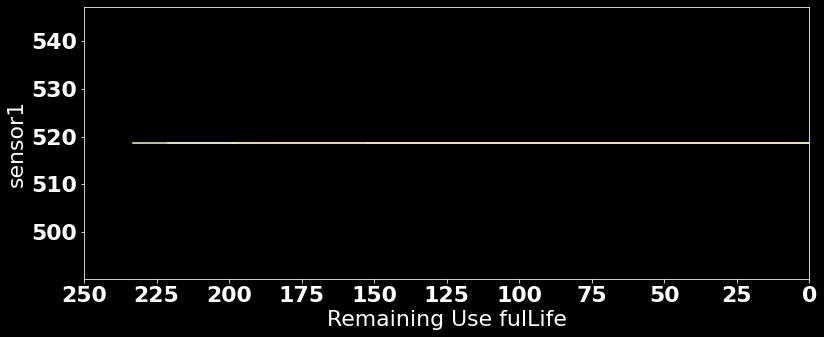

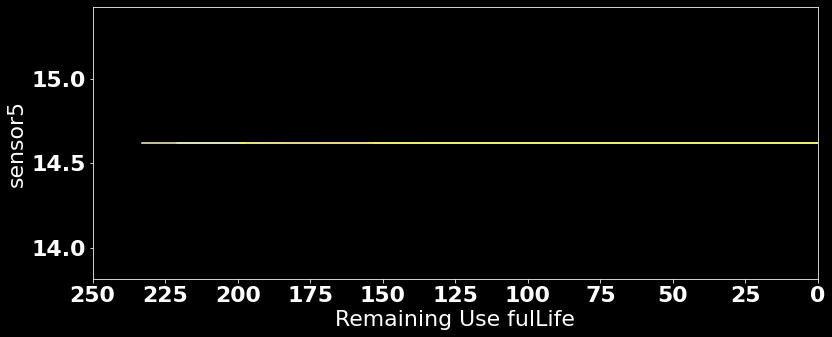

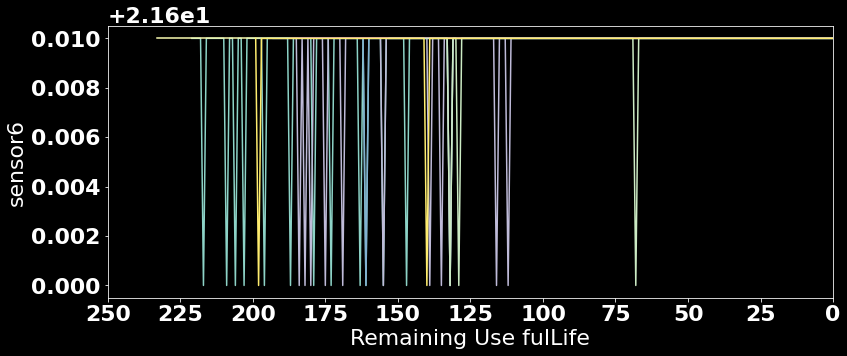

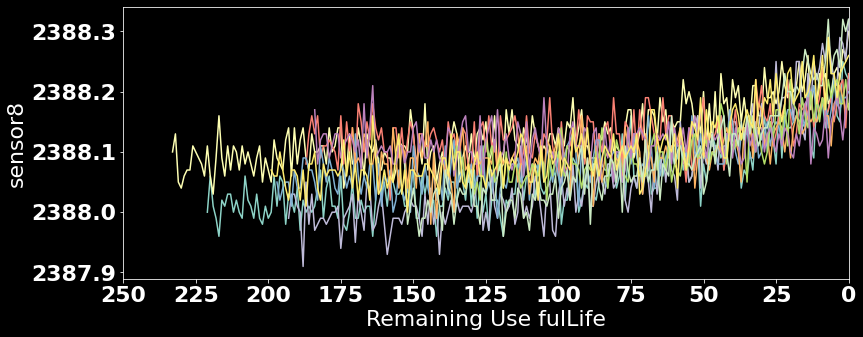

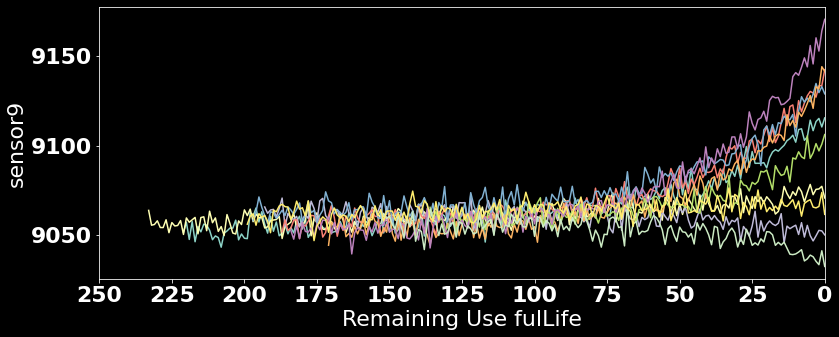

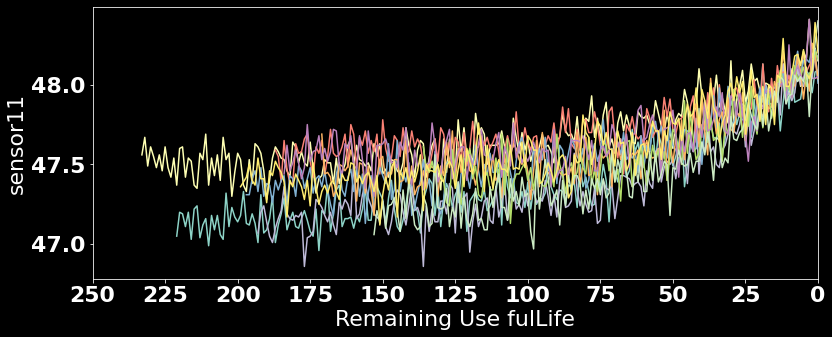

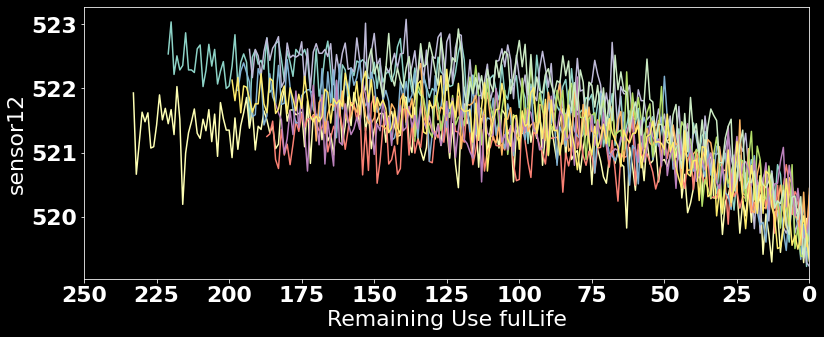

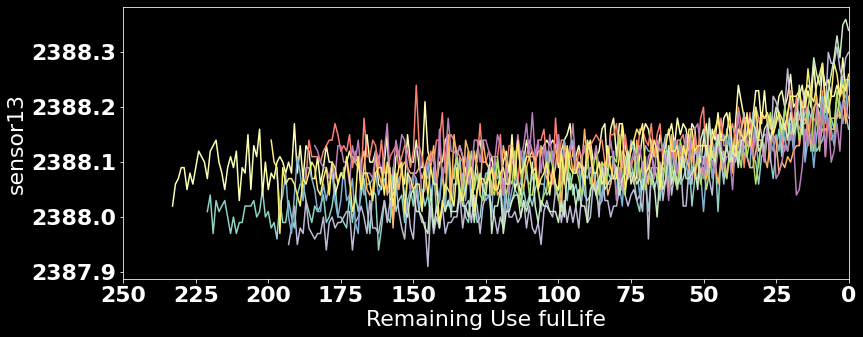

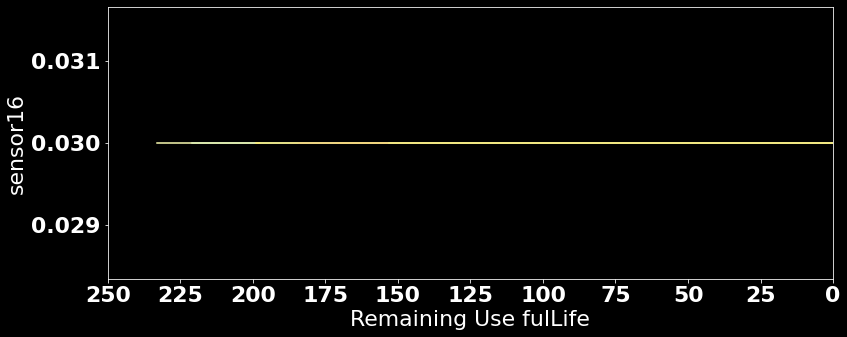

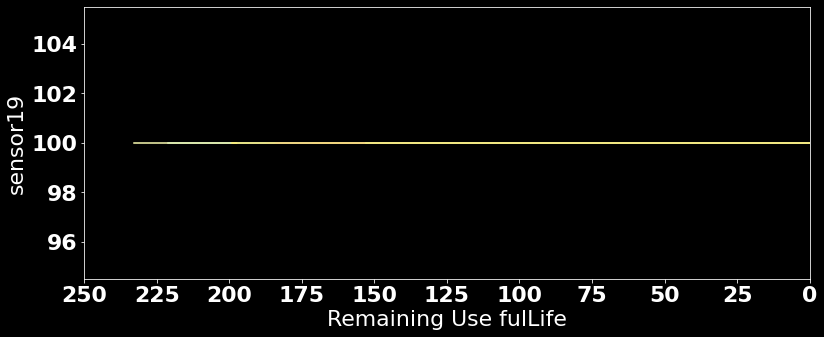

In [153]:
for sensor_name in sensor_names:
    plot_sensor(sensor_name)

In [157]:
train.columns

Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21',
       'sensor22', 'sensor23', 'RUL'],
      dtype='object')

In [158]:
def add_rul(df):
  grpbyid= df.groupby(by='id')
  max_c  = grpbyid['cycle'].max()

  res_frame = df.merge(max_c.to_frame(name='max_c'), left_on='id',right_index=True)
  res_frame["RUL"]= res_frame['max_c'] - res_frame['cycle']

   
  res_frame =  res_frame.drop("max_c", axis=1)
  return res_frame 
train = add_rul(train)

In [187]:
test = add_rul(test)

In [159]:
train.columns

Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21',
       'sensor22', 'sensor23', 'RUL'],
      dtype='object')

In [160]:
idx_names = ["id", "cycle"]
sensor_names = ["sensor" + str(i) for i in range(1,22)]
op_names = ['op1', 'op2', 'op3']
sensors_faulty =["sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","sensor22" , "sensor23"]

In [166]:
## train 
X_train = train.drop((op_names + sensors_faulty), axis=1 )

In [165]:
X_train

id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  \
0        1      1   641.82  1589.70  1400.60   554.36  2388.06  9046.19   
1        1      2   642.15  1591.82  1403.14   553.75  2388.04  9044.07   
2        1      3   642.35  1587.99  1404.20   554.26  2388.08  9052.94   
3        1      4   642.35  1582.79  1401.87   554.45  2388.11  9049.48   
4        1      5   642.37  1582.85  1406.22   554.00  2388.06  9055.15   
...    ...    ...      ...      ...      ...      ...      ...      ...   
20626  100    196   643.49  1597.98  1428.63   551.43  2388.19  9065.52   
20627  100    197   643.54  1604.50  1433.58   550.86  2388.23  9065.11   
20628  100    198   643.42  1602.46  1428.18   550.94  2388.24  9065.90   
20629  100    199   643.23  1605.26  1426.53   550.68  2388.25  9073.72   
20630  100    200   643.85  1600.38  1432.14   550.79  2388.26  9061.48   

       sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  \
0         47.47    521.66   2388.02   8138.62    8.4195       392     39.06   
1         47.49    522.28   2388.07   8131.49    8.4318       392     39.00   
2         47.27    522.42   2388.03   8133.23    8.4178       390     38.95   
3         47.13    522.86   2388.08   8133.83    8.3682       392     38.88   
4         47.28    522.19   2388.04   8133.80    8.4294       393     38.90   
...         ...       ...       ...       ...       ...       ...       ...   
20626     48.07    519.49   2388.26   8137.60    8.4956       397     38.49   
20627     48.04    519.68   2388.22   8136.50    8.5139       395     38.30   
20628     48.09    520.01   2388.24   8141.05    8.5646       398     38.44   
20629     48.39    519.67   2388.23   8139.29    8.5389       395     38.29   
20630     48.20    519.30   2388.26   8137.33    8.5036       396     38.37   

       sensor21  RUL  
0       23.4190  191  
1       23.4236  190  
2       23.3442  189  
3       23.3739  188  
4       23.4044  187  
...         ...  ...  
20626   22.9735    4  
20627   23.1594    3  
20628   22.9333    2  
20629   23.0640    1  
20630   23.0522    0  

[20631 rows x 17 columns]

## Basic Regression

In [180]:
# first create an evaluate function
from sklearn.metrics import mean_squared_error, r2_score
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [168]:
# target
y_train = X_train.pop('RUL')

In [193]:
X_test = test.drop(op_names + sensors_faulty, axis=1)

In [194]:
X_test.sample(5)

id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  \
872     9     32   642.87  1585.15  1407.44   553.78  2388.09  9057.57   
2146   19     31   642.16  1588.44  1396.33   554.06  2388.01  9056.65   
9489   73    112   642.27  1576.93  1398.62   554.41  2388.08  9051.39   
12385  95     26   642.61  1584.76  1398.17   554.70  2388.03  9045.48   
7854   61     72   642.22  1583.59  1405.26   554.59  2388.00  9065.56   

       sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  \
872       47.47    521.92   2388.08   8129.72    8.4309       392     38.91   
2146      47.22    521.96   2387.99   8134.20    8.3861       390     38.88   
9489      47.25    522.02   2388.05   8136.87    8.4317       393     38.95   
12385     47.37    521.88   2388.13   8124.47    8.4320       392     38.97   
7854      47.24    521.66   2387.96   8145.81    8.3932       390     38.87   

       sensor21  RUL  
872     23.2947   23  
2146    23.4977  104  
9489    23.3074    0  
12385   23.4194   63  
7854    23.3916   87

In [195]:
y_test = X_test.pop("RUL")

In [178]:
 ## create and fit model
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [181]:
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

train set RMSE:39.59310521746382, R2:0.6695837362220762


In [196]:
y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

test set RMSE:76.33849755230288, R2:-1.070249700704411


In [205]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 'sensor12', 'r',
                 data=train.loc[train['id']==20])
plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('sensor12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'g', linewidth=4,
                   data=train.loc[train['id']==20])
ax2.set_ylabel('RUL', labelpad=20)

# code to have equal spacing of y ticks for both axes, so the gridlines allign
# from https://stackoverflow.com/questions/20243683/matplotlib-align-twinx-tick-marks?rq=1
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis

# code to have a unified legend
# from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = signal+rul_line
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)


plt.show()

**For cycle 250 - 100 (or so) the mean sensor signal is rather stable, while computed RUL is declining.
Below 100 cycles, both the mean sensor signal and computed RUL are declining. In essence, the higher correlation between the sensor signal and computed RUL at lower RUL values makes it easier for the algorithm to produce more accurate predictions.**

## Lagged Elements

In [163]:
remaining_sensors =X_train.columns.difference(idx_names+['RUL'])

In [164]:
# lag of 1
lag1 = [col for col in remaining_sensors] 

In [143]:
X_train[lag1] = X_train.groupby('id')[remaining_sensors].shift(1)

In [144]:
X_train.dropna(inplace=True)

X_train.head()

id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  sensor11  \
3   1      4   641.82  1589.70  1400.60   554.36  2388.06  9046.19     47.47   
4   1      5   642.15  1591.82  1403.14   553.75  2388.04  9044.07     47.49   
5   1      6   642.35  1587.99  1404.20   554.26  2388.08  9052.94     47.27   
6   1      7   642.35  1582.79  1401.87   554.45  2388.11  9049.48     47.13   
7   1      8   642.37  1582.85  1406.22   554.00  2388.06  9055.15     47.28   

   sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  sensor21    RUL  
3    521.66   2388.02   8138.62    8.4195     392.0     39.06   23.4190  189.0  
4    522.28   2388.07   8131.49    8.4318     392.0     39.00   23.4236  188.0  
5    522.42   2388.03   8133.23    8.4178     390.0     38.95   23.3442  187.0  
6    522.86   2388.08   8133.83    8.3682     392.0     38.88   23.3739  186.0  
7    522.19   2388.04   8133.80    8.4294     393.0     38.90   23.4044  185.0

In [145]:
## test 
X_test = test.drop((op_names + sensors_faulty), axis=1 )

In [146]:
X_test.head()

id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  sensor11  \
0   1      1   643.02  1585.29  1398.21   553.90  2388.04  9050.17     47.20   
1   1      2   641.71  1588.45  1395.42   554.85  2388.01  9054.42     47.50   
2   1      3   642.46  1586.94  1401.34   554.11  2388.05  9056.96     47.50   
3   1      4   642.44  1584.12  1406.42   554.07  2388.03  9045.29     47.28   
4   1      5   642.51  1587.19  1401.92   554.16  2388.01  9044.55     47.31   

   sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  sensor21  
0    521.72   2388.03   8125.55    8.4052       392     38.86   23.3735  
1    522.16   2388.06   8139.62    8.3803       393     39.02   23.3916  
2    521.97   2388.03   8130.10    8.4441       393     39.08   23.4166  
3    521.38   2388.05   8132.90    8.3917       391     39.00   23.3737  
4    522.15   2388.03   8129.54    8.4031       390     38.99   23.4130

In [147]:
X_test[lag1] = X_test.groupby('id')[remaining_sensors].shift(1)

In [148]:
X_test

id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  \
0        1      1      NaN      NaN      NaN      NaN      NaN      NaN   
1        1      2   643.02  1585.29  1398.21   553.90  2388.04  9050.17   
2        1      3   641.71  1588.45  1395.42   554.85  2388.01  9054.42   
3        1      4   642.46  1586.94  1401.34   554.11  2388.05  9056.96   
4        1      5   642.44  1584.12  1406.42   554.07  2388.03  9045.29   
...    ...    ...      ...      ...      ...      ...      ...      ...   
13091  100    194   643.10  1595.60  1414.62   553.18  2388.08  9139.88   
13092  100    195   643.24  1599.45  1415.79   553.41  2388.02  9142.37   
13093  100    196   643.22  1595.69  1422.05   553.22  2388.05  9140.68   
13094  100    197   643.44  1593.15  1406.82   553.04  2388.11  9146.81   
13095  100    198   643.26  1594.99  1419.36   553.37  2388.07  9148.85   

       sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  \
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1         47.20    521.72   2388.03   8125.55    8.4052     392.0     38.86   
2         47.50    522.16   2388.06   8139.62    8.3803     393.0     39.02   
3         47.50    521.97   2388.03   8130.10    8.4441     393.0     39.08   
4         47.28    521.38   2388.05   8132.90    8.3917     391.0     39.00   
...         ...       ...       ...       ...       ...       ...       ...   
13091     47.58    521.37   2388.05   8213.57    8.4429     395.0     38.63   
13092     47.69    520.69   2388.00   8213.28    8.4715     394.0     38.65   
13093     47.60    521.05   2388.09   8210.85    8.4512     395.0     38.57   
13094     47.57    521.18   2388.04   8217.24    8.4569     395.0     38.62   
13095     47.61    521.33   2388.08   8220.48    8.4711     395.0     38.66   

       sensor21  
0           NaN  
1       23.3735  
2       23.3916  
3       23.4166  
4       23.3737  
...         ...  
13091   23.2952  
13092   23.1974  
13093   23.2771  
13094   23.2051  
13095   23.2699  

[13096 rows x 16 columns]

In [149]:
X_test.dropna(inplace=True)